In [21]:
! pip install langchain "unstructured[all-docs]" pydantic lxml

  Using cached protobuf-5.27.2-cp38-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
Using cached protobuf-5.27.2-cp38-abi3-macosx_10_9_universal2.whl (412 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
^C
ERROR: Operation cancelled by user


In [ ]:
! pip install -U langchain openai chromadb langchain-experimental # (newest versions required for multi-modal)

  Using cached protobuf-4.25.3-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
Using cached protobuf-4.25.3-cp37-abi3-macosx_10_9_universal2.whl (394 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.27.2
    Uninstalling protobuf-5.27.2:
      Successfully uninstalled protobuf-5.27.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.64.1 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.3 which is incompatible.


In [ ]:
! pip install pillow pydantic lxml pillow matplotlib chromadb tiktoken

In [ ]:
path = "/Users/ananyasai/Downloads/Clustering_InClass"

In [ ]:
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
##did brew install poppler to have the package to be able to process the pdf to access word count
## and brew install tesseract for unstructured

def extract_pdf_elements(path):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(
    filename=path +".pdf",
    extract_images_in_pdf=True,  # Using pdf format to find embedded image blocks
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

In [ ]:
# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    return texts, tables


In [ ]:
# Get elements
raw_pdf_elements = extract_pdf_elements(path)


Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Get text, tables
texts, tables = categorize_elements(raw_pdf_elements)

In [ ]:
texts

['Machine Learning Overview, EDA and Clustering\n\nMachine Learning Overview, EDA and Clustering Brian Wright brianwright@virginia.edu\n\nBrian Wright\n\nbrianwright@virginia.edu\n\nReeveuvasn 3 PRACTICE OF DATA SCIENCE\n\nCLASSICAL MACHINE LEARNING Data is on eal or numerical SUPERVISED Predict 5 Predict t al: a number SSIFICATION the socks by color» 2 ‘eB / REGRESSION «Divide the ties by Length» UNSUPERVISED Identify Sequences Divide by similarity Find hidden dependencies CLUSTERING «Split up similar clothing into Stacks” ci ASSOCIATION _—_ «Find what clothes | often = (: ; Wear togethern + = 2 °.m= DIMENSION REDUCTION (generalization) «Make the best outfits from the given clothes»\n\n2\n\nExample of K-Means\n\nGiven D :{2,4,10,12,3,11,20,25,30}, and k=2 clusters Randomly assign the means: m1=3, m2=4 K1={2,3}, K2={4,10,12,11,20,25,30}, m1=2.5, m2=16 K1={2,3,4}, K2={10,12,11,20,25,30}, m1=3, m2=18 K1={2,3,4,10}, K2={12,11,20,25,30}, m1=4.75, m2=19.6 K1={2,3,4,10,11,12}, K2={20,25,30},

In [ ]:
print(tables)

['Example use case General question Does Congress vote in patterns? Is there a pattern? Is there structure in unstructured data? Are basketball players "priced" efficiently (based on performance)? How to uncover trends with many variables that you can\'t easily visualize? Concept k-means clustering k-means clustering in many dimensions']


###Multi Vector Retriver

In [ ]:
! pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 575.6 kB/s eta 0:00:000:00:01


In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [ ]:
# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = ChatOpenAI(api_key=api_key,temperature=0, model="gpt-4")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


In [37]:
import os
import dotenv
dotenv.load_dotenv()

proj_key = os.getenv('IA-IN-HIGHERED')
org_id = os.getenv('Organzation-ID')
api_key = os.getenv('AI_KEY')

In [38]:
dotenv.load_dotenv()

True

In [ ]:
# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts, tables, summarize_texts=True
)

In [ ]:
text_summaries

['This text provides an overview of machine learning, exploratory data analysis (EDA), and clustering. It discusses classical machine learning, including supervised and unsupervised learning, regression, classification, clustering, association, and dimension reduction. It provides an example of K-means clustering with a given data set. The text also introduces unsupervised machine learning, discussing its application in Congress voting patterns and NBA player compensation. It defines EDA and its types, including clustering, network analysis, and text mining. The author of the text is Brian Wright.',
 'The text discusses unsupervised machine learning, specifically focusing on the concept of clustering. Clustering is a technique used to find similarities between groups and is a type of unsupervised machine learning. The similarity is usually defined by a distance metric, with the assumption that data points closer together are related or similar. The text also mentions a case study by GE

In [ ]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")



In [ ]:
def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(api_key=api_key, model="gpt-4o-mini", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


In [ ]:
# Image summaries
filepath = "/Users/ananyasai/Downloads/IA-in-HigherEd/figures"
img_base64_list, image_summaries = generate_img_summaries(filepath)

In [22]:
print(image_summaries)

['Title slide for a presentation on "Machine Learning Overview, EDA (Exploratory Data Analysis), and Clustering," authored by Brian Wright.', 'Text featuring the name "Brian Wright" prominently displayed in a formal or professional format.', 'Email address displayed: brianwright@virginia.edu. Text in a professional font and layout.', 'Abstract design featuring colorful dots radiating outward from a central circle with the text "PRACTICE OF DATA SCIENCE." The background is dark, enhancing the visual impact of the vibrant dots.', 'Illustration of the United States Capitol dome, featuring its iconic architectural details and golden statue on top.', 'A large assembly in a congressional chamber, featuring a speaker at a podium in front of an American flag, addressing a crowd of seated lawmakers and officials. The room is filled with attendees, showcasing a formal legislative session or address.', 'Scatter plot depicting the relationship between Aye and Nay votes in the House of Representati

## Add raw docs and doc summaries to Multi Vector Retriever

In [25]:
! pip install langchain_chroma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 2.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.27.2
    Uninstalling protobuf-5.27.2:
      Successfully uninstalled protobuf-5.27.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.64.1 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.4 which is incompatible.


In [26]:
import uuid
import langchain_chroma

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

In [41]:
def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag_cj_blog",
    embedding_function=OpenAIEmbeddings(openai_api_key= api_key)
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

##RAG, building portions of the retriever, that will take the documents and bin the retrieved doc(s) into the correct parts of the GPT-4o-mini prompt template

In [42]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image

In [43]:
def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}

In [44]:
def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are a teaching assistant for a foundations of machine learning class tasked with answering student questions related to the concepts.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide machine learning advice and concept clarification related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(api_key=api_key,temperature=0, model="gpt-4o-mini", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

##Checking its utility

In [48]:
# Check retrieval
query = "What is clustering in Machine Learning?"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# We get 4 docs
len(docs)

4

In [49]:
docs

['Unsupervised machine learning\n\nThe data inputs have (x) no target outputs (y)\n\nInput x: Voter\n\n?\n\nOutput y: Not given (To be discovered)\n\nWe want to impose structure on the inputs (x)to say something meaningful about the data\n\n7\n\nWhat is clustering?\n\n1. Technique for finding similarity between groups\n\n2. Type of unsupervised machine learning\n\n• Not the only class of unsupervised learning algorithms\n\n3. Similarity needs to be defined\n\nWill depend on attributes of data • Usually a distance metric\n\nKey assumption: data points that are “closer” together are related or similar\n\n8\n\nC\n\nGE Capital case study: grouping clients\n\nHaimowitz and Schwarz 1997 paper on clustering for credit line optimization – http://www.aaai.org/Papers/Workshops/1997/\n\nWS-97-07/WS97-07-006.pdf\n\n• Cluster existing GE Capital customers based on similarity in use of their credit cards to pay bills and customers’ profitability to GE Capital\n\n• Resulted in five clusters of consum

In [51]:
# We get back relevant images
plt_img_base64(docs)


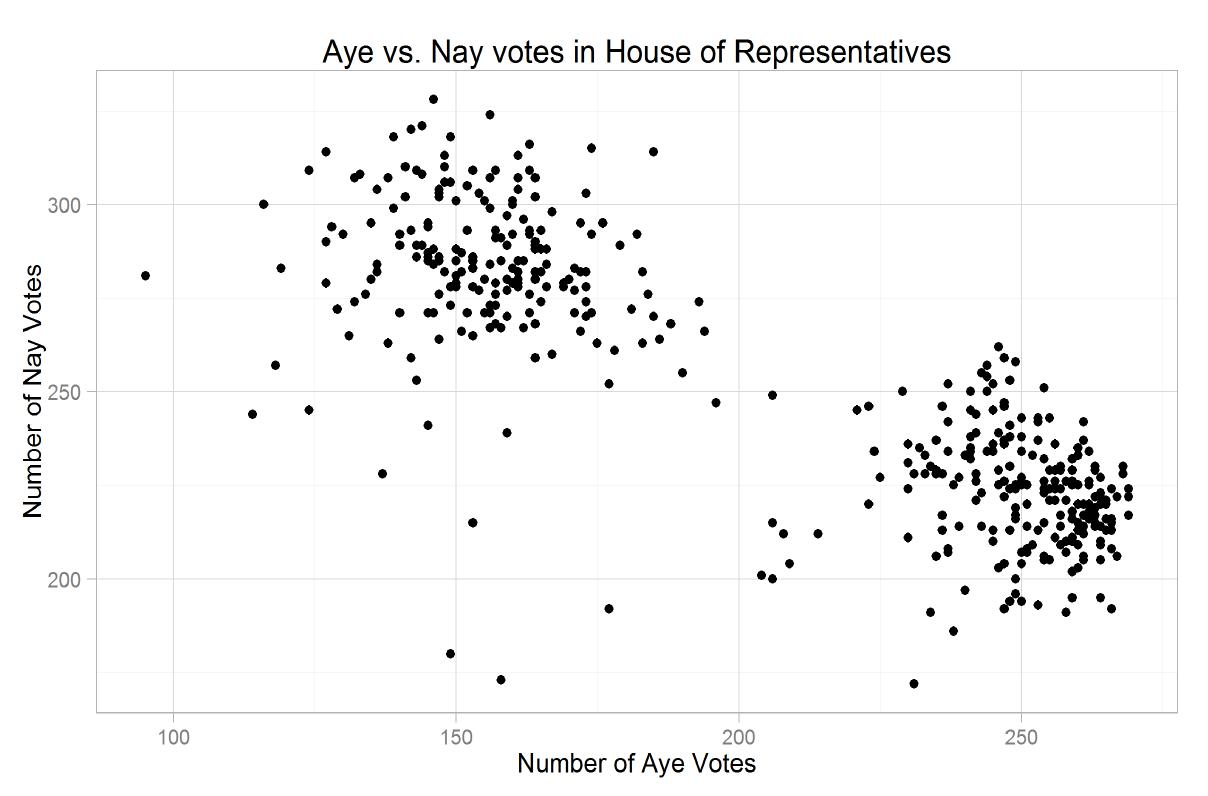

In [55]:
plt_img_base64(img_base64_list[6])

In [56]:
image_summaries[6]

'Scatter plot depicting the relationship between Aye and Nay votes in the House of Representatives. The x-axis represents the number of Aye votes, while the y-axis indicates the number of Nay votes. The data points are scattered, showing a general trend of decreasing Nay votes as Aye votes increase.'

##Running RAG to see if it will find an answer to our query

In [57]:
# Run RAG chain
chain_multimodal_rag.invoke(query)

'Clustering is a fundamental concept in machine learning, particularly within the realm of unsupervised learning. Here’s a breakdown of what clustering entails based on the information provided:\n\n### What is Clustering?\n\n1. **Definition**: Clustering is a technique used to group a set of objects in such a way that objects in the same group (or cluster) are more similar to each other than to those in other groups. This similarity is often defined using a distance metric, which quantifies how close or far apart the data points are in the feature space.\n\n2. **Unsupervised Learning**: Clustering falls under the category of unsupervised machine learning, meaning that it does not rely on labeled output data (i.e., there are no predefined categories or target outputs). Instead, the goal is to discover the inherent structure of the data.\n\n3. **Similarity Measurement**: The effectiveness of clustering depends on how similarity is defined. Common distance metrics include Euclidean distan